In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
cnx = sqlite3.connect('Database/Civ6CitySettledData.db')
cur = cnx.cursor()
print(cnx)
print(cur)

## Retrieve the city growth and performance data
cityPerTurnView contains all the relevant data captured for each city per turn of the game. I align the number of turns the city has existed so we can make an elapsed turn based evaluation.

The base identity for this database is the cityId. That is, in this database (and experiment) is designed to look at city growth over time. The same cityName can occur in multiple games so when we add the recorded information for the game we create new cityIds.

In [4]:
sqlSelect = 'SELECT * FROM cityPerTurnView WHERE turns >= 1 and turns <= 50'
cityPt = pd.read_sql_query(sqlSelect, cnx)
# Did the following directly in the database query ;-)
#cptv = cptv[cptv['turns'].between(1, 50, inclusive=True)]
print(cityPt.shape)
print(cityPt.dtypes)

(6400, 29)
cityId                 int64
gameId                 int64
settledById            int64
currentOwnerId         int64
cityName              object
settledByName         object
settledByCiv          object
currentOwnerName      object
currentOwnerCiv       object
settledOnTurn          int64
gameTurn               int64
turns                  int64
foodPerTurn          float64
foodToolTip           object
productionPerTurn    float64
productionToolTip     object
goldPerTurn          float64
goldToolTip           object
sciencePerTurn       float64
scienceToolTip        object
culturePerTurn       float64
cultureToolTip        object
faithPerTurn         float64
faithToolTip          object
population             int64
housing                int64
amenities              int64
amenitiesNeeded        int64
happiness             object
dtype: object


In [4]:
def showYieldMetrics(yld, topBottomN):
    columnName = "{}PerTurn".format(yld.lower())
    cumulativeDf = cityPt[['cityId', 'turns', columnName]].pivot(index='turns',
                                                                 columns='cityId',
                                                                 values=columnName).cumsum()
    t50 = cumulativeDf.loc[50]

    print("\n{}:-\nsummary statistics:".format(yld))
    print("     max: {:.2f}".format(t50.max()))
    print("     min: {:.2f}".format(t50.min()))
    print("    mean: {:.2f}".format(t50.mean()))
    print("  median: {:.2f}".format(t50.median()))
    print("     std: {:.2f}".format(t50.std()))
    print("\nQuantiles:")
    print(pd.DataFrame(t50.quantile([.2, .4, .6, .8])).T)
    print("\n")

    topN = pd.DataFrame(list(zip(list(t50.nlargest(topBottomN).values),
                                list(t50.nlargest(topBottomN).index.values)
                            )
                    ), columns=["{}Total".format(yld.lower()), 'cityId'])
    bottomN = pd.DataFrame(list(zip(list(t50.nsmallest(topBottomN).values),
                                    list(t50.nsmallest(topBottomN).index.values)
                               )
                          ), columns=["{}Total".format(yld.lower()), 'cityId'])
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4), tight_layout=True)

    cumulativeDf.plot(ax=axes[0], kind='line', legend=False, title="{} - Per city".format(yld))
    axes[0].set_xlabel('Turns since settled')
    axes[0].set_ylabel("{} (cumulative)".format(yld))

    t50.plot(ax=axes[1], kind='hist', legend=False, bins=9, title="{} - Histogram of total".format(yld))
    axes[1].set_xlabel("Total {} by turn 50".format(yld))

    t50.plot(ax=axes[2], kind='box', legend=False, title="{} - Boxplot".format(yld), notch=True)
    axes[2].set_xlabel('Distribution at turn 50')

    plt.show()
    plt.close()

    # Redefining t50 to be the last per turn rows in the dataframe!
    t50 = cityPt[cityPt['turns'] == 50]
    tCitiesDf = topN.set_index('cityId').join(t50.set_index('cityId'))
    bCitiesDf = bottomN.set_index('cityId').join(t50.set_index('cityId'))

    yld = yld.lower()
    print("\nTop {} {} cities:".format(topBottomN, yld))
    print(tCitiesDf[["{}Total".format(yld), "{}PerTurn".format(yld), 'settledByName', 
                     'population', 'housing', 'happiness', "{}ToolTip".format(yld)]])
    print("\n\nBottom {} {} cities:".format(topBottomN, yld))
    print(bCitiesDf[["{}Total".format(yld), "{}PerTurn".format(yld), 'settledByName', 
                     'population', 'housing', 'happiness', "{}ToolTip".format(yld)]])

## Food


Food:-
summary statistics:
     max: 762.00
     min: 194.00
    mean: 427.84
  median: 417.50
     std: 129.67

Quantiles:
      0.2    0.4    0.6    0.8
50  306.2  380.0  449.2  531.4




C:\Users\leon\Miniconda3\lib\site-packages\matplotlib\figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


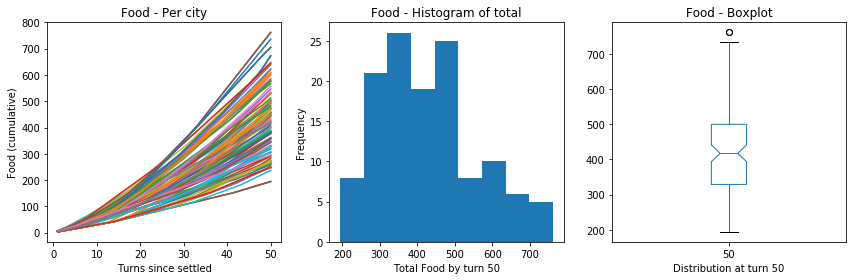


Top 10 food cities:
        foodTotal  foodPerTurn    settledByName  population  housing  \
cityId                                                                 
91          762.0         21.0        Jerusalem           7        8   
106         762.0         21.0        Jerusalem           7        8   
41          736.0         20.0           Muscat           7        8   
96          705.0         16.0            Peter           6        7   
111         705.0         16.0            Peter           6        7   
86          673.0         25.0  Mvemba a Nzinga           7       11   
101         673.0         25.0  Mvemba a Nzinga           7       11   
69          649.0         16.0          Lautaro           5        8   
89          645.0         16.0         Auckland           6        9   
104         645.0         16.0         Auckland           6        9   

         happiness                                        foodToolTip  
cityId                                    

In [5]:
showYieldMetrics('Food', 10)

## Production


Production:-
summary statistics:
     max: 721.20
     min: 76.95
    mean: 296.10
  median: 201.95
     std: 184.65

Quantiles:
       0.2     0.4     0.6     0.8
50  131.14  180.06  250.28  496.96




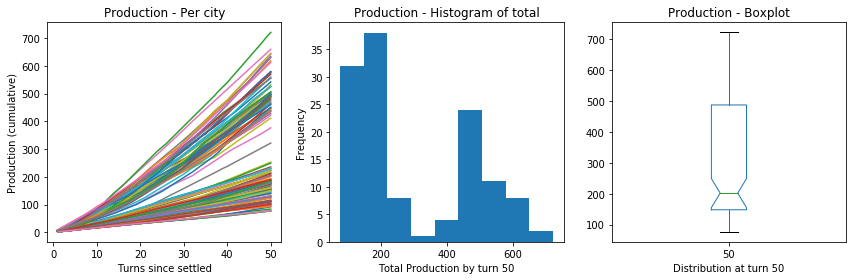


Top 10 production cities:
        productionTotal  productionPerTurn         settledByName  population  \
cityId                                                                         
83               721.20              17.25  Frederick Barbarossa           5   
67               660.20              14.40              Pericles           4   
84               644.40              16.80             Philip II           5   
99               644.40              16.80             Philip II           5   
115              634.75              16.25               Lautaro           2   
68               630.35              17.50          Genghis Khan           4   
82               618.80              16.80               Tomyris           6   
117              612.55              14.95             Montezuma           5   
96               579.40              14.95                 Peter           6   
111              579.40              14.95                 Peter           6   

        hous

In [6]:
showYieldMetrics('Production', 10)

## Gold


Gold:-
summary statistics:
     max: 731.20
     min: 246.75
    mean: 340.33
  median: 298.10
     std: 114.38

Quantiles:
       0.2      0.4     0.6     0.8
50  257.25  275.026  317.93  392.89




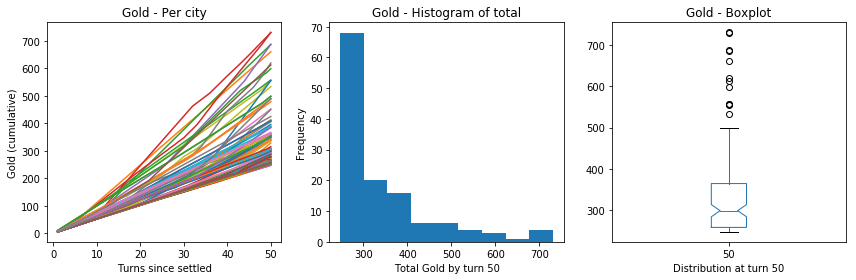


Top 10 gold cities:
        goldTotal  goldPerTurn         settledByName  population  housing  \
cityId                                                                      
24         731.20        21.25       Harald Hardrada           2        6   
54         730.20        16.25            Poundmaker           5        6   
23         687.80        16.25              Seondeok           5        7   
25         687.05        21.60                Trajan           5        7   
2          660.70        13.75             Montezuma           4        8   
68         619.65        23.75          Genghis Khan           4        8   
116        612.55        15.00         Hojo Tokimune           4        6   
83         599.05        14.95  Frederick Barbarossa           5       10   
53         557.60        11.70                 Shaka           2        6   
29         556.25        16.25               Tomyris           5        6   

         happiness                                    

In [7]:
showYieldMetrics('Gold', 10)

## Science


Science:-
summary statistics:
     max: 331.38
     min: 150.22
    mean: 190.54
  median: 181.75
     std: 32.72

Quantiles:
        0.2     0.4      0.6     0.8
50  165.674  175.61  189.486  203.09




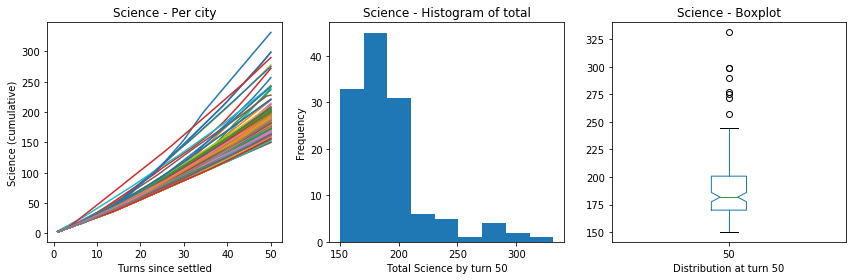


Top 10 science cities:
        scienceTotal  sciencePerTurn    settledByName  population  housing  \
cityId                                                                       
71            331.38            8.47        Gilgamesh           3        6   
86            298.58            8.47  Mvemba a Nzinga           7       11   
101           298.58            8.47  Mvemba a Nzinga           7       11   
114           289.96            6.78         Victoria           4        7   
19            277.52            7.02            Peter           5        7   
51            275.01            6.48  Teddy Roosevelt           4        6   
54            272.07            8.47       Poundmaker           5        6   
21            256.87            8.47       Wilhelmina           3        7   
52            244.08            6.69  Mvemba a Nzinga           5        7   
70            242.42            5.65        Philip II           4        7   

         happiness                     

In [8]:
showYieldMetrics('Science', 10)

## Culture


Culture:-
summary statistics:
     max: 297.01
     min: 87.62
    mean: 151.67
  median: 151.20
     std: 36.88

Quantiles:
        0.2    0.4      0.6      0.8
50  119.352  145.5  153.592  173.806




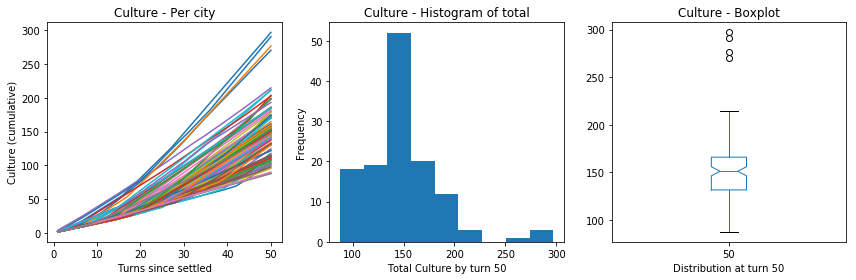


Top 10 culture cities:
        cultureTotal  culturePerTurn    settledByName  population  housing  \
cityId                                                                       
21            297.01            7.79       Wilhelmina           3        7   
51            290.64            7.77  Teddy Roosevelt           4        6   
82            276.91            7.34          Tomyris           6        8   
71            270.48            6.66        Gilgamesh           3        6   
25            214.68            4.86           Trajan           5        7   
10            211.89            6.09           Geneva           6       10   
120           210.97            5.20         La Venta           4        8   
54            203.65            7.34       Poundmaker           5        6   
114           202.63            4.74         Victoria           4        7   
98            198.87            6.21    Hojo Tokimune           5        8   

       happiness                       

In [9]:
showYieldMetrics('Culture', 10)

## Faith


Faith:-
summary statistics:
     max: 350.12
     min: 0.00
    mean: 28.49
  median: 0.00
     std: 65.39

Quantiles:
    0.2  0.4  0.6     0.8
50  0.0  0.0  0.0  33.772




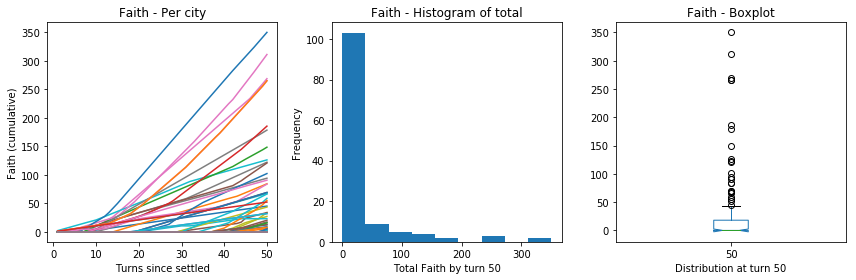


Top 10 faith cities:
        faithTotal  faithPerTurn        settledByName  population  housing  \
cityId                                                                       
51          350.12          8.64      Teddy Roosevelt           4        6   
27          311.27         10.17                Cyrus           5        6   
7           268.84          9.04     Robert the Bruce           4        7   
97          265.19          9.27              Gitarja           6        8   
112         265.19          9.27              Gitarja           6        8   
114         185.52          6.78             Victoria           4        7   
68          178.52          4.52         Genghis Khan           4        8   
23          148.56          4.52             Seondeok           5        7   
20          126.25          2.10              Gitarja           5        7   
8           122.17          3.39  Catherine de Medici           4        7   

         happiness                       

In [10]:
showYieldMetrics('Faith', 10)

## Population

7
2
4.421875
4.0


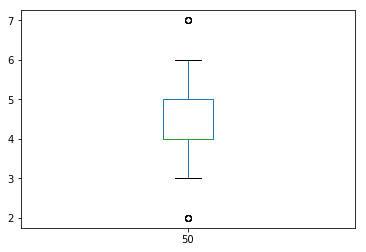

In [11]:
popDf = cityPt[['cityId', 'turns', 'population']].pivot(index='turns',
                                                        columns='cityId',
                                                        values='population')
t50 = popDf.loc[50]

print(t50.max())
print(t50.min())
print(t50.mean())
print(t50.median())

t50.plot.box()

In [12]:
# Code testing how to get turn next pop reached
#df = pd.DataFrame({"A": [1,2,2,2,3],
#                   "B": [1,2,2,3,3],
#                   "C": [1,2,3,3,4],
#                   "D": [1,1,1,2,2]}, index=[1,2,3,4,5])
#print(df)
#maxPop = df.max().max()
#newDf = pd.DataFrame(columns=df.columns.values.tolist(), index=range(1,maxPop+1))
#print(newDf)
#
#for i in range(1,maxPop+1):
#    for j in df.columns.values.tolist():
#        s = df[j]
#        try:
#            s = int(s[s == i].index[0])
#        except IndexError:
#            s = 0
#        newDf.loc[i,j] = s
#print(newDf.astype('int64'))

In [13]:
maxPop = popDf.max().max()
popGrowthDf = pd.DataFrame(columns=popDf.columns.values.tolist(), index=range(1, maxPop + 1))
for i in range(1,maxPop+1):
    for j in popDf.columns.values.tolist():
        s = popDf[j]
        try:
            turnNextPopReached = int(s[s == i].index[0])
        except IndexError:
            # Using NaN messes up types so using 0 to indicate never reached that pop!
            turnNextPopReached = 0
        popGrowthDf.loc[i,j] = turnNextPopReached
popGrowthDf = popGrowthDf.T.astype('int64')
print(popGrowthDf.shape)

(128, 7)


In [14]:
print("Population growth descriptive statistics:\n")
print("Columns represent the population, Rows the descriptive measure")
print("count shows the drop-off in number of city with larger population")
popGrowthStats = pd.DataFrame()
for i in popGrowthDf.columns.values.tolist():
    s = popGrowthDf.loc[:,i]
    s = s[s != 0]
    #print(s.describe())
    popGrowthStats[i] = s.describe()
print(popGrowthStats.round(1))

Population growth descriptive statistics:

Columns represent the population, Rows the descriptive measure
count shows the drop-off in number of city with larger population
           1      2      3      4     5     6     7
count  128.0  128.0  125.0  104.0  63.0  24.0   5.0
mean     1.0    8.4   19.8   30.4  37.3  41.5  45.2
std      0.0    3.2    8.4    9.7   8.5   6.4   4.0
min      1.0    3.0    9.0   15.0  21.0  30.0  41.0
25%      1.0    6.0   13.0   22.8  30.5  37.8  41.0
50%      1.0    8.0   19.0   30.0  39.0  42.0  46.0
75%      1.0    8.0   23.0   36.2  45.5  47.0  49.0
max      1.0   15.0   44.0   50.0  50.0  50.0  49.0


## Housing

11
4
7.3515625
7.0


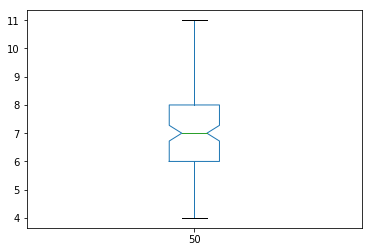

In [15]:
housingDf = cityPt[['cityId', 'turns', 'housing']].pivot(index='turns',
                                                         columns='cityId',
                                                         values='housing')
t50 = housingDf.loc[50]

print(t50.max())
print(t50.min())
print(t50.mean())
print(t50.median())

t50.plot.box(notch=True)

## Amenities

5
1
1.578125
1.0


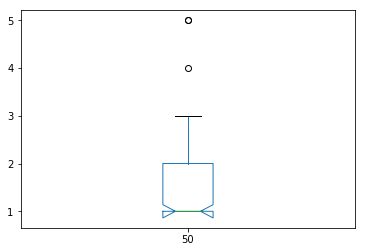

In [16]:
amenitiesDf = cityPt[['cityId', 'turns', 'amenities']].pivot(index='turns',
                                                         columns='cityId',
                                                         values='amenities')
t50 = amenitiesDf.loc[50]
print(t50.max())
print(t50.min())
print(t50.mean())
print(t50.median())

t50.plot.box(notch=True)

3
0
1.4609375
1.0


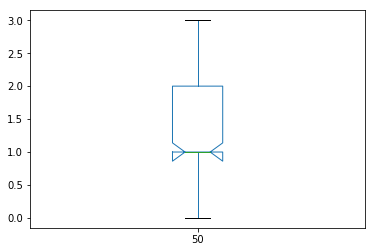

In [17]:
amenitiesNeededDf = cityPt[['cityId', 'turns', 'amenitiesNeeded']].pivot(index='turns',
                                                         columns='cityId',
                                                         values='amenitiesNeeded')
t50 = amenitiesNeededDf.loc[50]
print(t50.max())
print(t50.min())
print(t50.mean())
print(t50.median())

t50.plot.box(notch=True)

## Happiness

In [18]:
happinessDf = cityPt[['cityId', 'turns', 'happiness']].pivot(index='turns',
                                                         columns='cityId',
                                                         values='happiness')
#print(happinessDf.shape)

happinessVals = set([])
for columnName in happinessDf.columns.values.tolist():
    vals = happinessDf[columnName].unique().tolist()
    for item in vals:
        happinessVals.add(item)
#print(happinessVals)

turnsPerHappinessValue = pd.DataFrame()
for columnName in happinessDf.columns.values.tolist():
    for val in happinessVals:
        s = happinessDf[columnName]
        turnsPerHappinessValue.loc[val, columnName] = s[s == val].count()
print("\nPer city number of turns per happiness state:")
print(turnsPerHappinessValue)
print("\nAverage number of turns per happiness state across all the cities:")
print(turnsPerHappinessValue.T.mean())




Per city number of turns per happiness state:
             1     2     3     4     5     6     7     8     9     10   ...   \
Content      0.0   1.0  26.0   0.0  26.0  30.0  38.0   9.0  16.0  24.0  ...    
Ecstatic     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
Happy       50.0  49.0  15.0  50.0  12.0  20.0  12.0  41.0  34.0  13.0  ...    
Displeased   0.0   0.0   9.0   0.0  12.0   0.0   0.0   0.0   0.0  13.0  ...    

             119   120   121   122   123   124   125   126   127   128  
Content     20.0  22.0  32.0  25.0  32.0   6.0  21.0  21.0  34.0   0.0  
Ecstatic     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   7.0  
Happy       30.0  28.0  18.0  12.0  18.0  44.0  29.0  29.0  16.0  43.0  
Displeased   0.0   0.0   0.0  13.0   0.0   0.0   0.0   0.0   0.0   0.0  

[4 rows x 128 columns]

Average number of turns per happiness state across all the cities:
Content       20.070312
Ecstatic       0.109375
Happy         25.140625
Displeased     4.679688

## Look at individual city metrics

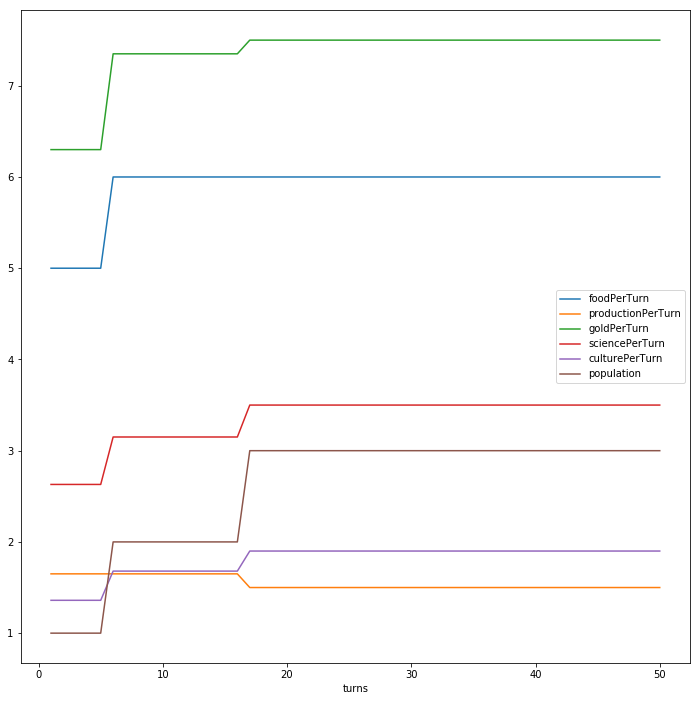

In [7]:
cityIdToGetMetrics = 127
cityData = cityPt[(cityPt.cityId == cityIdToGetMetrics)]
cityGraphData = cityData[['turns','foodPerTurn', 'productionPerTurn', 'goldPerTurn', 'sciencePerTurn', 'culturePerTurn', 'population']]
cityGraphData.set_index('turns', inplace=True)

cityGraphData.plot(kind='line', figsize=(12,12))


In [22]:
cur.close()
cnx.close()